# *lsforce* example script: Forward model
---

This example script demonstrates the usage of *lsforce* for creating synthetic seismic data given a user-supplied force-time function and network of real (or fake) stations. The code makes use of the helper function `make_lsdata_syn()`, which creates the `LSData` object *lsforce* requires for Green's function generation.

`make_lsdata_syn()` allows users to specify **real** stations via an ObsPy [Inventory](https://docs.obspy.org/packages/autogen/obspy.core.inventory.inventory.Inventory.html) object; **fake** stations are provided as a dictionary of station names and coordinates. Either or both of these inputs are allowed; the following example uses both inputs to mix real and fake stations.

### Import necessary modules

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from obspy import Stream, Trace, UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth
from scipy.signal.windows import blackmanharris

from lsforce import LSData, LSForce, LSTrajectory, make_lsdata_syn

# Ignore benign Matplotlib backend warning due to fig.show()
import warnings

warnings.filterwarnings(
    action='ignore', message='FigureCanvasAgg is non-interactive', category=UserWarning
)

### Define some constants, set up folder structure

In [2]:
LS_LAT, LS_LON = (60.0273, -153.0683)  # Where the user-supplied force will be applied

FAKE_DATA_LENGTH = 400  # [s]
FAKE_DATA_SAMPLING_RATE = 1  # [Hz]

PERIOD_RANGE = (15, 80)  # [s] Bandpass filter corners for GFs

# Set up folder structure
main_folder = Path.cwd() / 'forward'
if not main_folder.exists():
    main_folder.mkdir()

### Create LSData object

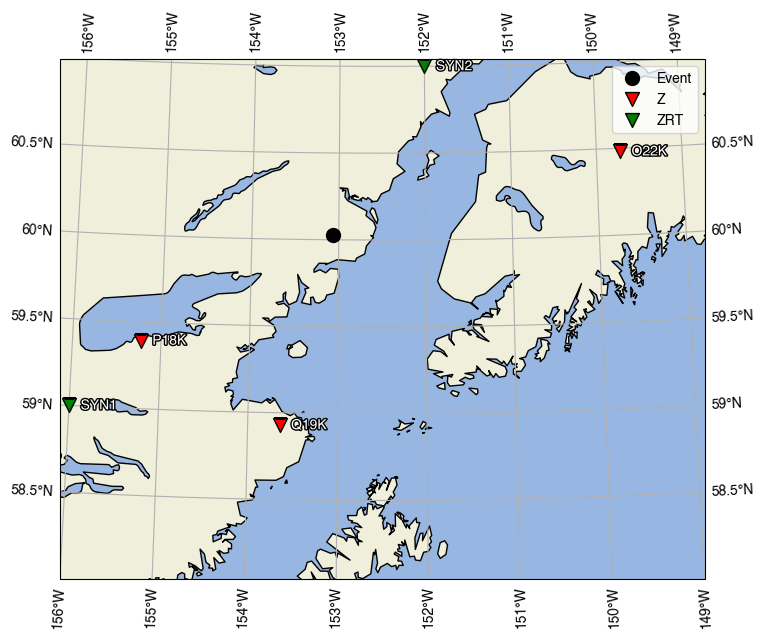

In [3]:
client = Client('IRIS')

# Create Inventory of *real* stations (NOTE: level MUST be 'channel')
inv = client.get_stations(
    network='TA', station='O22K,P18K,Q19K', channel='BHZ', level='channel'
)

# Create dictionary of *fake* stations
FAKE_STATION_DICT = dict(
    SYN1=[59.0, -156.0],
    SYN2=[61.0, -152.0],
)

# Create synthetic LSData object
data_syn = make_lsdata_syn(
    inv=inv,
    fake_station_dict=FAKE_STATION_DICT,
    source_lat=LS_LAT,
    source_lon=LS_LON,
    data_length_seconds=FAKE_DATA_LENGTH,
)

# Plot stations
data_syn.plot_stations(label_stations=True);

### Setup

In [4]:
force = LSForce(
    data=data_syn, data_sampling_rate=FAKE_DATA_SAMPLING_RATE, main_folder=main_folder
)

force.setup(
    period_range=PERIOD_RANGE,
    syngine_model='iasp91_2s',
)

Getting Green's functions...
Downloaded O22K (1/5)
Downloaded P18K (2/5)
Downloaded Q19K (3/5)
Downloaded SYN1 (4/5)
Downloaded SYN2 (5/5)


### Create synthetic force-time function

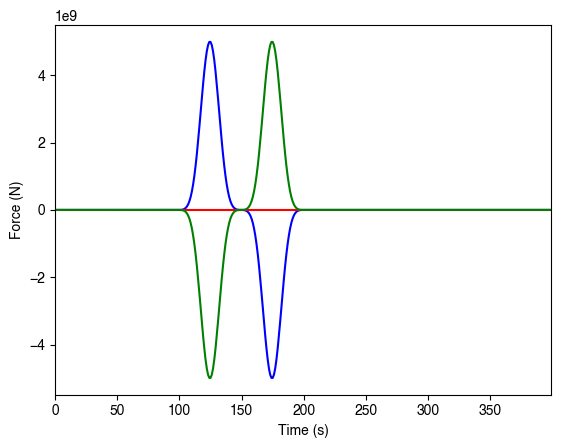

In [5]:
# Make function
t = np.arange(0, FAKE_DATA_LENGTH, 1 / FAKE_DATA_SAMPLING_RATE)  # [s] Time vector
max_force = 5e9  # [N] Peak force
fake_force_z = max_force * np.hstack(
    [
        np.zeros(t.size // 4),
        blackmanharris(t.size // 8),
        -blackmanharris(t.size // 8),
        np.zeros(t.size // 2),
    ]
)
fake_force_n = np.zeros(fake_force_z.size)
fake_force_e = -fake_force_z

# Plot this function
fig, ax = plt.subplots()
ax.plot(t, fake_force_z, color='blue', label='Up')
ax.plot(t, fake_force_n, color='red', label='North')
ax.plot(t, fake_force_e, color='green', label='East')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Force (N)')
ax.autoscale(axis='x', tight=True)
plt.show()

### Forward model

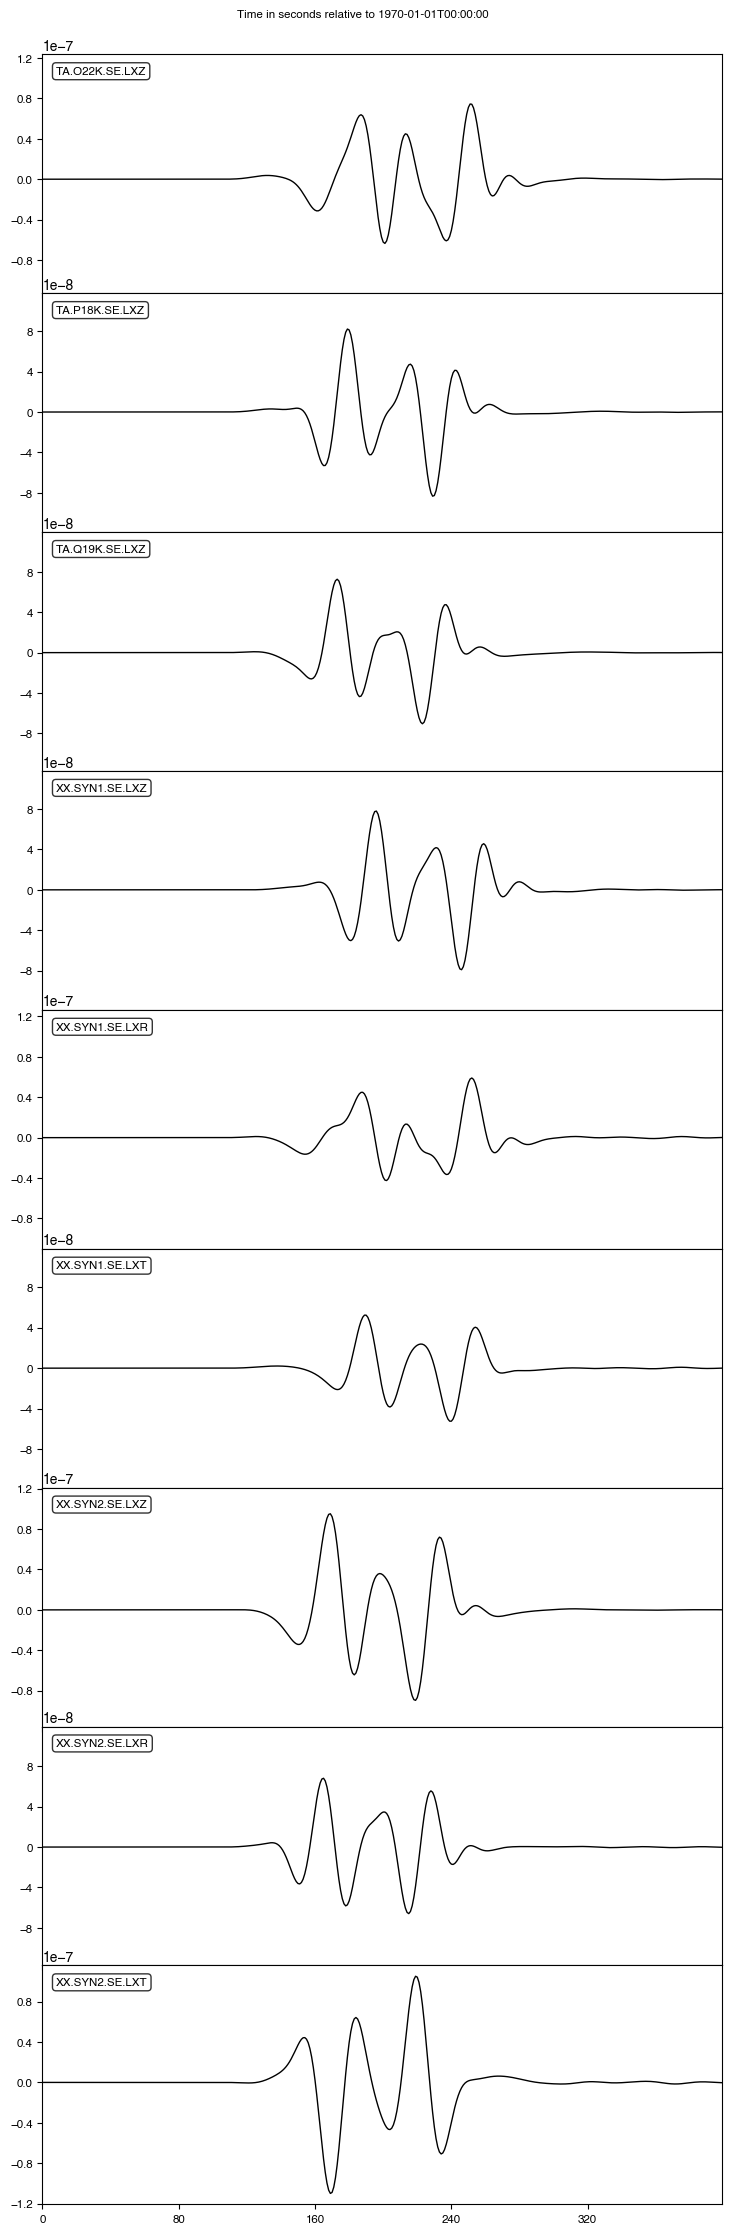

In [6]:
st_syn = force.forward(fake_force_z, fake_force_n, fake_force_e)
st_syn.plot(type='relative');